In [ ]:
"""
@author: jpzxshi
"""
import torch
import torch.nn as nn

from module import Module, StructureNN

class LinearModule(Module):
    '''Linear symplectic module.
    '''
    def __init__(self, dim, layers):
        super(LinearModule, self).__init__()
        self.dim = dim
        self.layers = layers
        
        self.params = self.__init_params()
        
    def forward(self, pqh):
        p, q, h = pqh[0], pqh[1], pqh[2]
        for i in range(self.layers):
            S = self.params['S{}'.format(i + 1)]
            if i % 2 == 0:
                p = p + q @ (S + S.t()) * h
            else:
                q = p @ (S + S.t()) * h + q
        return p + self.params['bp'] * h, q + self.params['bq'] * h
    
    def __init_params(self):
        '''Si is distributed N(0, 0.01), and b is set to zero.
        '''
        d = int(self.dim / 2)
        params = nn.ParameterDict()
        for i in range(self.layers):
            params['S{}'.format(i + 1)] = nn.Parameter((torch.randn([d, d]) * 0.01).requires_grad_(True))
        params['bp'] = nn.Parameter(torch.zeros([d]).requires_grad_(True))
        params['bq'] = nn.Parameter(torch.zeros([d]).requires_grad_(True))
        return params
        
class ActivationModule(Module):
    '''Activation symplectic module.
    '''
    def __init__(self, dim, activation, mode):
        super(ActivationModule, self).__init__()
        self.dim = dim
        self.activation = activation
        self.mode = mode
        
        self.params = self.__init_params()
        
    def forward(self, pqh):
        p, q, h = pqh[0], pqh[1], pqh[2]
        if self.mode == 'up':
            return p + self.act(q) * self.params['a'] * h, q
        elif self.mode == 'low':
            return p, self.act(p) * self.params['a'] * h + q
        else:
            raise ValueError
            
    def __init_params(self):
        d = int(self.dim / 2)
        params = nn.ParameterDict()
        params['a'] = nn.Parameter((torch.randn([d]) * 0.01).requires_grad_(True))
        return params
            
class GradientModule(Module):
    '''Gradient symplectic module.
    '''
    def __init__(self, dim, width, activation, mode):
        super(GradientModule, self).__init__()
        self.dim = dim
        self.width = width
        self.activation = activation
        self.mode = mode
        
        self.params = self.__init_params()
        
    def forward(self, pqh):
        p, q, h = pqh[0], pqh[1], pqh[2]
        if self.mode == 'up':
            gradH = (self.act(q @ self.params['K'] + self.params['b']) * self.params['a']) @ self.params['K'].t()
            return p + gradH * h, q
        elif self.mode == 'low':
            gradH = (self.act(p @ self.params['K'] + self.params['b']) * self.params['a']) @ self.params['K'].t()
            return p, gradH * h + q
        else:
            raise ValueError
            
    def __init_params(self):
        d = int(self.dim / 2)
        params = nn.ParameterDict()
        params['K'] = nn.Parameter((torch.randn([d, self.width]) * 0.01).requires_grad_(True))
        params['a'] = nn.Parameter((torch.randn([self.width]) * 0.01).requires_grad_(True))
        params['b'] = nn.Parameter(torch.zeros([self.width]).requires_grad_(True))
        return params
    
class SympNet(StructureNN):
    def __init__(self):
        super(SympNet, self).__init__()
        self.dim = None
        
    def predict(self, xh, steps=1, keepinitx=False, returnnp=False):
        dim = xh.size(-1)
        size = len(xh.size())
        if dim == self.dim:
            pred = [xh]
            for _ in range(steps):
                pred.append(self(pred[-1]))
        else:
            x0, h = xh[..., :-1], xh[..., -1:] 
            pred = [x0]
            for _ in range(steps):
                pred.append(self(torch.cat([pred[-1], h], dim=-1)))
        if keepinitx:
            steps = steps + 1
        else:
            pred = pred[1:]
        res = torch.cat(pred, dim=-1).view([-1, steps, self.dim][2 - size:])
        return res.cpu().detach().numpy() if returnnp else res

class LASympNet(SympNet):
    '''LA-SympNet.
    Input: [num, dim] or [num, dim + 1]
    Output: [num, dim]
    '''
    def __init__(self, dim, layers=3, sublayers=2, activation='sigmoid'):
        super(LASympNet, self).__init__()
        self.dim = dim
        self.layers = layers
        self.sublayers = sublayers
        self.activation = activation
        
        self.modus = self.__init_modules()
        
    def forward(self, pqh):
        d = int(self.dim / 2)
        if pqh.size(-1) == self.dim + 1:
            p, q, h = pqh[..., :d], pqh[..., d:-1], pqh[..., -1:]
        elif pqh.size(-1) == self.dim:
            p, q, h = pqh[..., :d], pqh[..., d:], torch.ones_like(pqh[..., -1:])
        else:
            raise ValueError
        for i in range(self.layers - 1):
            LinM = self.modus['LinM{}'.format(i + 1)]
            ActM = self.modus['ActM{}'.format(i + 1)]
            p, q = ActM([*LinM([p, q, h]), h])
        return torch.cat(self.modus['LinMout']([p, q, h]), dim=-1)
    
    def __init_modules(self):
        modules = nn.ModuleDict()
        for i in range(self.layers - 1):
            modules['LinM{}'.format(i + 1)] = LinearModule(self.dim, self.sublayers)
            mode = 'up' if i % 2 == 0 else 'low'
            modules['ActM{}'.format(i + 1)] = ActivationModule(self.dim, self.activation, mode)
        modules['LinMout'] = LinearModule(self.dim, self.sublayers)
        return modules

Set up dataset:

In [14]:
import numpy as np
from torch.utils.data import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

class LorentzDataset(Dataset):
    def __init__(self, data, train=True, split_idx=1200):
        super(LorentzDataset, self).__init__()
        self.v = data[:, :2] #v1, v2 -> p
        self.x = data[:, 2:] #x1, x2 -> q

        #split the dataset based on split_idx, we use 1200 as defined within the problem
        if train:
            self.v = self.v[:split_idx]
            self.x = self.x[:split_idx]
        else:
            self.v = self.v[split_idx:]
            self.x = self.x[split_idx:]

    def __len__(self):
        return len(self.v) - 1

    def __getitem__(self, idx):
        curr_state = torch.FloatTensor(np.concatenate([self.v[idx], self.x[idx]])) #FloatTensor -> 32b fp32
        next_state = torch.FloatTensor(np.concatenate([self.v[idx+1], self.x[idx+1]]))
        h = torch.FloatTensor([0.1]) #as defined within the problem

        return torch.cat([curr_state, h]), next_state

Train the SympNet:

In [15]:
#load in data -> v1, v2, x1, x2
data = np.loadtxt('data_lorentz/train.txt')

#split/setup data (1200 vs. 300)
train_dataset = LorentzDataset(data, train=True)
test_dataset = LorentzDataset(data, train=False)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#model params
dim = 4 #the problem degenerates into 2D dynamics
model = LASympNet(dim=dim, layers=7, sublayers=7, activation='tanh')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)

num_epochs = 4000
train_losses = []
test_losses = []

epoch = 0
train_loss = 0
test_loss = 0

pbar = tqdm(range(num_epochs), desc=f'Epoch {epoch}, train loss: {train_loss}, test loss: {test_loss}')

for epoch in pbar:
    model.train()
    tot_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
            
        loss.backward()
        optimizer.step()
            
        tot_loss += loss.item()
    
    train_loss = tot_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()

    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)

    pbar.set_description(f"Epoch {epoch+1} | Train: {train_loss} | Test: {test_loss}")

pbar.close()

Epoch 4000 | Train: 0.0009731188275557207 | Test: 0.0009702726849354804: 100%|██████████| 4000/4000 [06:23<00:00, 10.42it/s]


Visualize the loss:

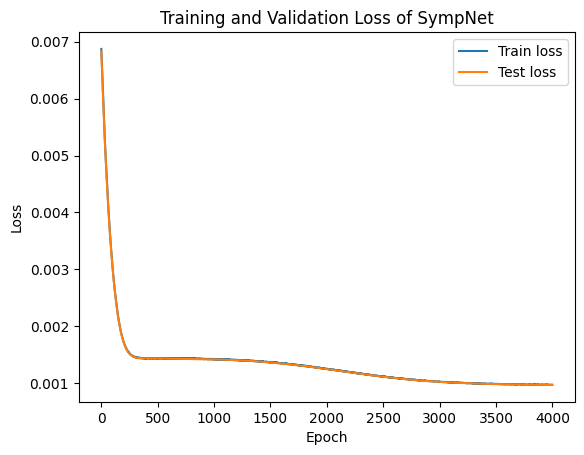

In [16]:
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss of SympNet")
plt.legend()

loss_data = pd.DataFrame({
    "epoch": range(1, len(train_losses) + 1),
    "train_loss": train_losses,
    'test_loss': test_losses
})

loss_data.to_csv('sympnet_losses.csv', index=False)

In [17]:
def predict_trajectory(model, initial_state, num_steps, h):
    curr_state = torch.FloatTensor(initial_state)
    h = torch.FloatTensor([float(h)])

    traj = [current_state.numpy()]

    for i in range(num_steps):
        with torch.no_grad():
            input_state = torch.cat([current_state, h])
            next_state = model(input_state)
            traj.append(next_state.numpy())
            curr_state = next_state

    return np.array(traj)

In [18]:
test_inputs = []
test_targets = []

for i in range(len(test_dataset)):
    inp, target = test_dataset[i]
    test_inputs.append(inp.numpy())
    test_targets.append(target.numpy())

test_input = np.array(test_inputs)
test_targets = np.array(test_targets)

model.eval()
with torch.no_grad():
    test_predictions = model(torch.FloatTensor(test_inputs)).numpy()

assert(len(test_inputs) == len(test_targets))

Visualize predictions:

Text(0.5, 1.0, 'Trajectory of Particle Over Time')

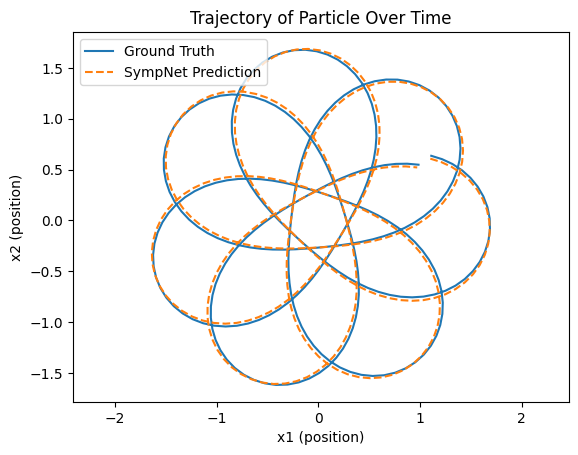

In [21]:
#split back into v1, v2, x1, x2
test_predictions_v = test_predictions[:, :2] #v1, v2
test_predictions_x = test_predictions[:, 2:] #x1, x2

test_targets_v = test_targets[:, :2] #v1, v2
test_targets_x = test_targets[:, 2:] #x1, x2

plt.plot(test_targets_x[:, 0], test_targets_x[:, 1], label="Ground Truth")
plt.plot(test_predictions_x[:, 0], test_predictions_x[:, 1], label="SympNet Prediction", linestyle='--')
plt.legend()
plt.axis("equal")
plt.xlabel("x1 (position)")
plt.ylabel("x2 (position)")
plt.title("Trajectory of Particle Over Time")

Calculate MSE/time:

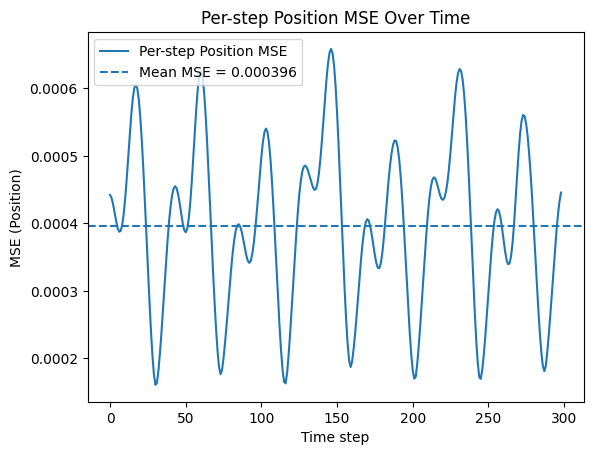

In [26]:
mse_per_step_velocity = np.mean((test_targets[:, :2] - test_predictions[:, :2])**2, axis=1)
mse_per_step_position = np.mean((test_targets[:, 2:] - test_predictions[:, 2:])**2, axis=1)
tot_velocity_mse = np.mean(mse_per_step_velocity)
tot_position_mse = np.mean(mse_per_step_position)

plt.plot(np.arange(len(mse_per_step_position)), mse_per_step_position, label='Per-step Position MSE')
plt.axhline(y=tot_position_mse, linestyle='--', label=f'Mean MSE = {tot_position_mse:.6f}')
plt.xlabel('Time step')
plt.ylabel('MSE (Position)')
plt.title('Per-step Position MSE Over Time')
plt.legend()

#save for comparison
loss_data = pd.DataFrame({
    "time_step": np.arange(len(mse_per_step_position)),
    "mse_per_step_position": mse_per_step_position,
})

loss_data.to_csv('mse_position_sympnet.csv', index=False)